In [1]:
import numpy as np
pi = np.pi
sqrt = np.sqrt
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy import stats
import os, time

from IPython.display import clear_output

In [2]:
# make grid of tangent projection centers
alphasdeg = np.linspace(40,-60,11) # elevation opposite from gensim
alphasrad = np.multiply(pi/180,alphasdeg)
thetasdeg = np.linspace(-180,180,36,endpoint=False)# azimuth
thetasrad = np.multiply(pi/180,thetasdeg)

# make local points and handle reprojection to different locations 

def makegrid(fovdeg=10,res=10,f=1.0):
    xlim = f*np.tan(fovdeg/2 * pi/180)
    xx,yy = np.meshgrid(np.linspace(-xlim,xlim,res),np.linspace(-xlim,xlim,res))
    return xx,yy

# based on fish studies, each mode is 25 samples over 40 deg field of view
xx,yy = makegrid(fovdeg=40,res=5)
xx = np.ndarray.flatten(xx)
yy = np.ndarray.flatten(yy)
patchsz = 25

def pitch(a):
    return np.array([[1,0,0],[0,np.cos(a),np.sin(a)],[0,-np.sin(a),np.cos(a)]])

def yaw(a):
    return np.array([[np.cos(a),0,np.sin(a)],[0,1,0],[-np.sin(a),0,np.cos(a)]])

def roll(a):
    return np.array([[np.cos(a),-np.sin(a),0],[np.sin(a),np.cos(a),0],[0,0,1]])

def makeR(theta,alpha=0,gamma=0):
    return np.matmul(np.matmul(roll(gamma),pitch(alpha)),yaw(theta))

In [3]:
# create flows for different velocities and geometries

# geometries
def nearness_local(geometry='natural',x=xx,y=yy,r=1,f=1,alpha=0):
    if geometry == 'sphere':
        mu = 1/r*np.sqrt(1-(x**2+y**2))
    elif geometry == 'floor':
        mu = np.abs(np.sin(y+alpha))/r * (y+alpha < 0)
    elif geometry == 'natural':
        mu = 10*np.abs(np.sin(alpha+np.arctan2(y,f))) # 10 cm above/10 cm below (Z*.1m -> mu*10/m)
        mu[(alpha+np.arctan2(y,f))>42*pi/180] = 0 # remove geometry cues above Snell's window
    return mu

# flow from velocity
def getflow_local(Vx=0,Vy=0,Vz=0,Wx=0,Wy=0,Wz=0,
              geometry='sphere',r=1,f=1,
              x=xx,y=yy,theta=0,alpha=0):
    
    # rotate velocity to local patch
    V0 = [[Vx,Vy,Vz],[Wx,Wy,Wz]]
    R = makeR(theta,alpha)
    V = np.transpose(np.matmul(R,np.transpose(V0)))
    Vx,Vy,Vz = V[0]
    Wx,Wy,Wz = V[1]
    
    # get nearness
    mu = nearness_local(geometry=geometry,x=x,y=y,r=r,alpha=alpha)
    
    # compute local flow
    flow_horiz = -Vx*f*mu + Vz*mu*x - Wx*x*y/f + Wy*(f**2+x**2)/f - Wz*y
    flow_vert = -Vy*f*mu + Vz*mu*y - Wx*(f**2+y**2)/f + Wy*x*y/f + Wz*x
    
    return flow_horiz,flow_vert

# multi-modal flow patches
def getflow_multimodal(Vx=0,Vy=0,Vz=0,Wx=0,Wy=0,Wz=0,
              geometry='sphere',r=1,f=1,
              x=xx,y=yy,thetas=[0,0],alphas=[0,0]):
    
    flow_horiz = np.zeros(patchsz*len(thetas))
    flow_vert = np.zeros_like(flow_horiz)
    for i in range(len(thetas)):
        flow_h, flow_v = getflow_local(Vx=Vx,Vy=Vy,Vz=Vz,Wx=Wx,Wy=Wy,Wz=Wz,
              geometry=geometry,r=r,f=f,
              x=x,y=y,theta=thetas[i],alpha=alphas[i])
        flow_horiz[i*patchsz:(i+1)*patchsz] = flow_h
        flow_vert[i*patchsz:(i+1)*patchsz] = flow_v
    return flow_horiz,flow_vert

''

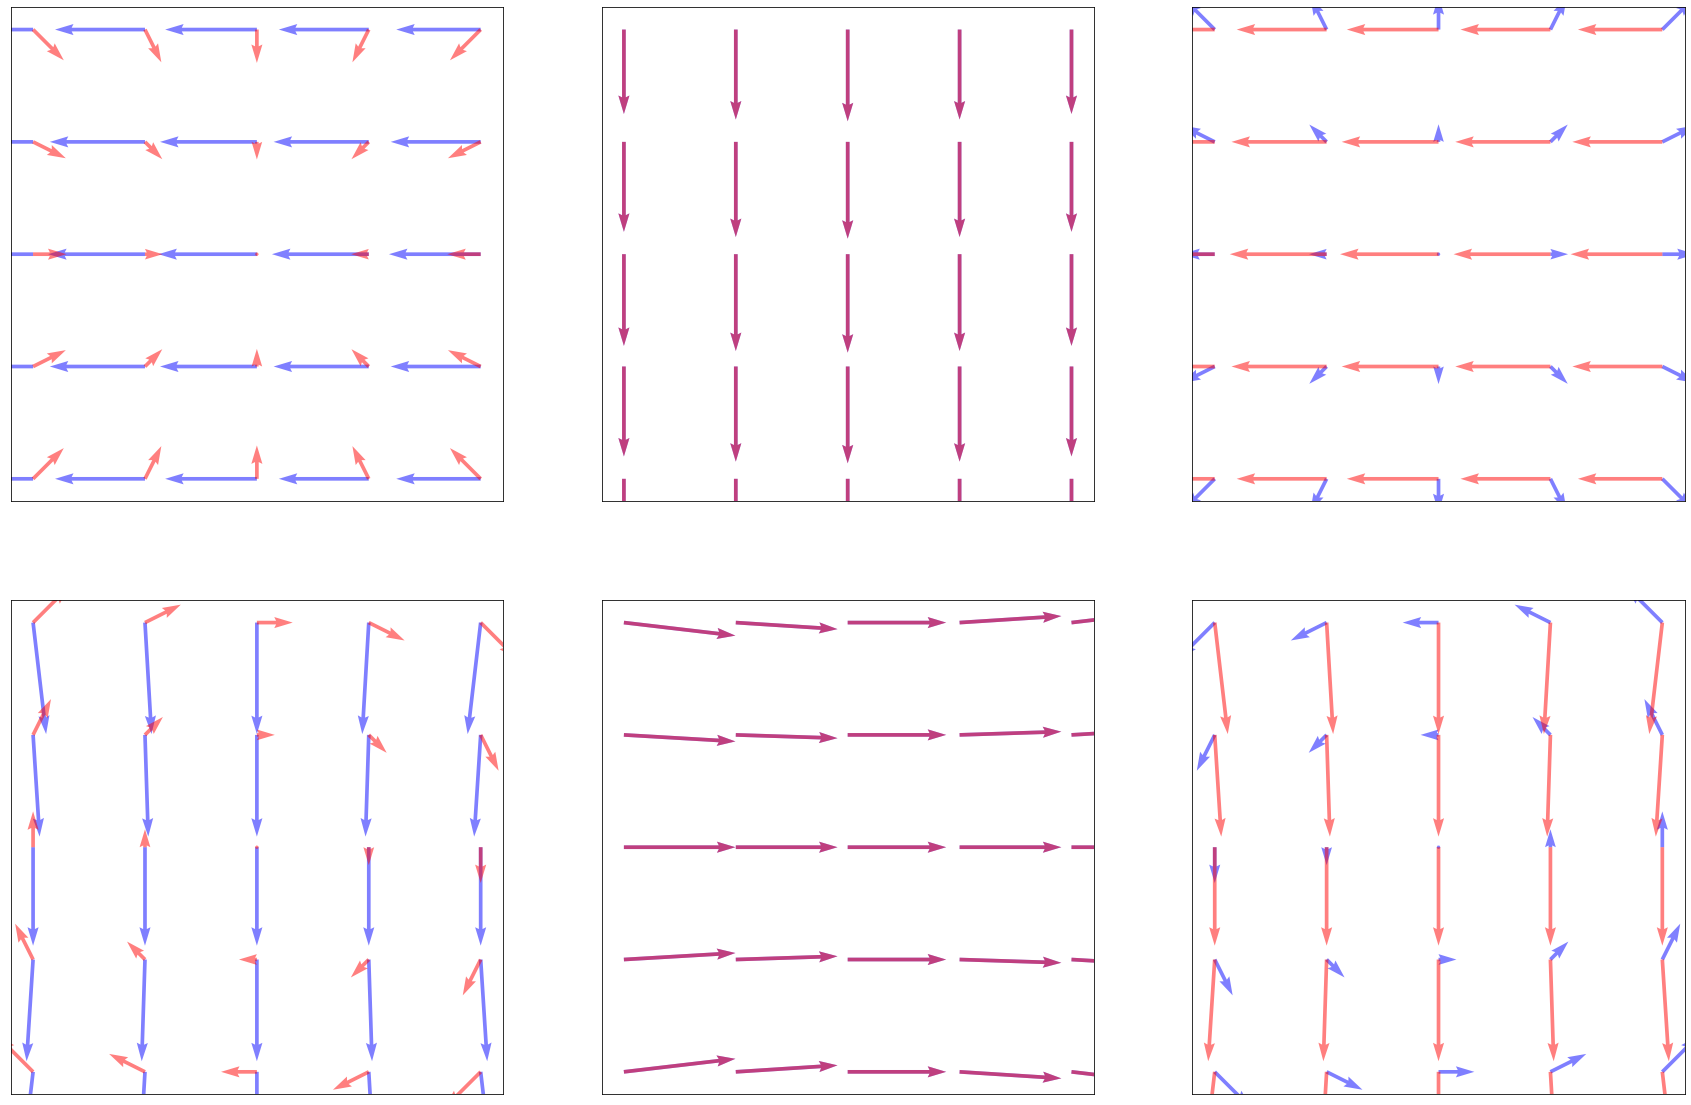

In [4]:
# show local templates
alphas=[0,0]
thetas=[0,pi/2]

s = 5 # make this bigger to make arrows smaller

halfres=False
if halfres:
    #xgrid,ygrid= makegrid(fovdeg=10,res=5)
    xgrid,ygrid= makegrid(fovdeg=60,res=5)
    xgrid = np.ndarray.flatten(xgrid)
    ygrid = np.ndarray.flatten(ygrid)
else:
    xgrid = xx
    ygrid = yy

xgrid2 = [xgrid,xgrid]
ygrid2 = [ygrid,ygrid]
    
plt.figure(figsize=(30,20))

plt.subplot(2,3,1)
template = getflow_multimodal(Vx=1,alphas=alphas,thetas=thetas,x=xgrid,y=ygrid)
plt.quiver(xgrid,ygrid,template[0][:25],template[1][:25],scale=s,color='b',alpha=.5)
plt.quiver(xgrid,ygrid,template[0][25:],template[1][25:],scale=s,color='r',alpha=.5)
plt.axis('equal')
plt.yticks([],[])
plt.xticks([],[])

plt.subplot(2,3,2)
template = getflow_multimodal(Vy=1,alphas=alphas,thetas=thetas,x=xgrid,y=ygrid)
plt.quiver(xgrid,ygrid,template[0][:25],template[1][:25],scale=s,color='b',alpha=.5)
plt.quiver(xgrid,ygrid,template[0][25:],template[1][25:],scale=s,color='r',alpha=.5)
plt.axis('equal')
plt.yticks([],[])
plt.xticks([],[])


plt.subplot(2,3,3)
template = getflow_multimodal(Vz=1,alphas=alphas,thetas=thetas,x=xgrid,y=ygrid)
plt.quiver(xgrid,ygrid,template[0][:25],template[1][:25],scale=s,color='b',alpha=.5)
plt.quiver(xgrid,ygrid,template[0][25:],template[1][25:],scale=s,color='r',alpha=.5)
plt.axis('equal')
plt.yticks([],[])
plt.xticks([],[])


plt.subplot(2,3,4)
template = getflow_multimodal(Wx=1,alphas=alphas,thetas=thetas,x=xgrid,y=ygrid)
plt.quiver(xgrid,ygrid,template[0][:25],template[1][:25],scale=s,color='b',alpha=.5)
plt.quiver(xgrid,ygrid,template[0][25:],template[1][25:],scale=s,color='r',alpha=.5)
plt.axis('equal')
plt.yticks([],[])
plt.xticks([],[])

plt.subplot(2,3,5)
template = getflow_multimodal(Wy=1,alphas=alphas,thetas=thetas,x=xgrid,y=ygrid)
plt.quiver(xgrid,ygrid,template[0][:25],template[1][:25],scale=s,color='b',alpha=.5)
plt.quiver(xgrid,ygrid,template[0][25:],template[1][25:],scale=s,color='r',alpha=.5)
plt.axis('equal')
plt.yticks([],[])
plt.xticks([],[])


plt.subplot(2,3,6)
template = getflow_multimodal(Wz=1,alphas=alphas,thetas=thetas,x=xgrid,y=ygrid)
plt.quiver(xgrid,ygrid,template[0][:25],template[1][:25],scale=s,color='b',alpha=.5)
plt.quiver(xgrid,ygrid,template[0][25:],template[1][25:],scale=s,color='r',alpha=.5)
plt.axis('equal')
plt.yticks([],[])
plt.xticks([],[])
;

In [5]:
# predict self motion velocity from local flow patch
def getvel_multimodal(flow,thetas=[0,0],alphas=[0,0],x=xx,y=yy,geometry='sphere',DOFs=6,weightsin=np.ones(2*len(xx))):
   
    vxtemplate = np.ndarray.flatten(np.array(getflow_multimodal(Vx=1,thetas=thetas,alphas=alphas,geometry=geometry,x=x,y=y)))
    vytemplate = np.ndarray.flatten(np.array(getflow_multimodal(Vy=1,thetas=thetas,alphas=alphas,geometry=geometry,x=x,y=y)))
    vztemplate = np.ndarray.flatten(np.array(getflow_multimodal(Vz=1,thetas=thetas,alphas=alphas,geometry=geometry,x=x,y=y)))
    wxtemplate = np.ndarray.flatten(np.array(getflow_multimodal(Wx=1,thetas=thetas,alphas=alphas,geometry=geometry,x=x,y=y)))
    wytemplate = np.ndarray.flatten(np.array(getflow_multimodal(Wy=1,thetas=thetas,alphas=alphas,geometry=geometry,x=x,y=y)))
    wztemplate = np.ndarray.flatten(np.array(getflow_multimodal(Wz=1,thetas=thetas,alphas=alphas,geometry=geometry,x=x,y=y)))    
        
    if DOFs == 1:
        templates = wytemplate #note: in previous experiments (GenSim) 1DOF was Vz
    elif DOFs == 2:
        templates = np.stack([vxtemplate,vztemplate])
    elif DOFs == 3:
        templates = np.stack([vxtemplate,vztemplate,wytemplate])
    elif DOFs == 6:
        templates = np.stack([vxtemplate,vytemplate,vztemplate,wxtemplate,wytemplate,wztemplate])
    
    # remove locations where flow is missing
    weights = np.ones(np.shape(flow)[1])
    weights[np.isnan(flow[0])] = 0
    weights[np.isnan(flow[1])] = 0
    flow[0][np.isnan(flow[0])] = 0
    flow[1][np.isnan(flow[1])] = 0
    
    # weight template and sample
    template = np.transpose(templates*np.tile(weights,[DOFs,2]))
    sample = np.transpose(np.ndarray.flatten(np.array(flow))*np.tile(weights,[1,2]))
    
    # solve for self motion
    pred,_,_,_ = np.linalg.lstsq(template,sample,rcond=-1)
    return np.squeeze(pred)


# angle difference for heading error`
def anglediff(a,b,deg=False):
    if deg:
        return np.arctan2(np.sin((a-b)*np.pi/180),np.cos((a-b)*np.pi/180))*180/np.pi
    else:
        return np.arctan2(np.sin(a-b),np.cos(a-b))

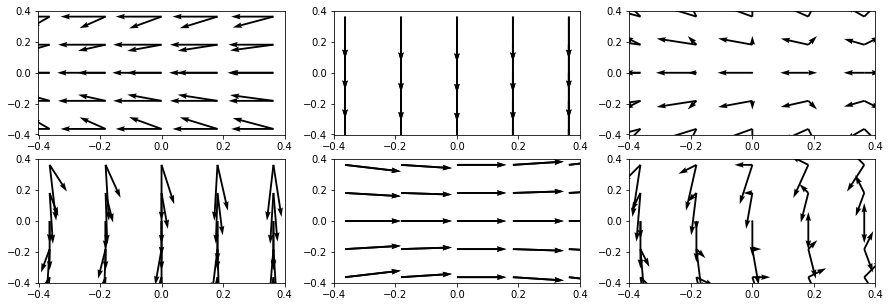

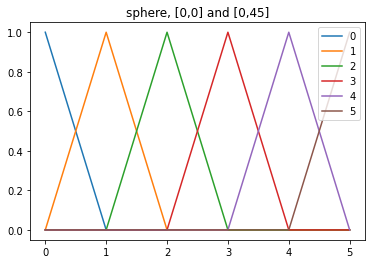

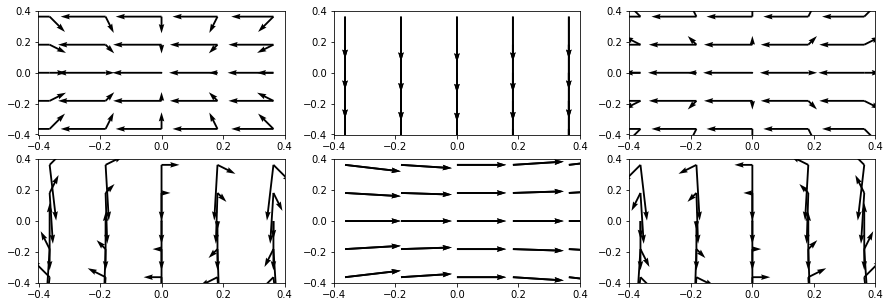

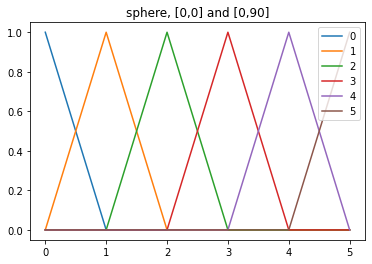

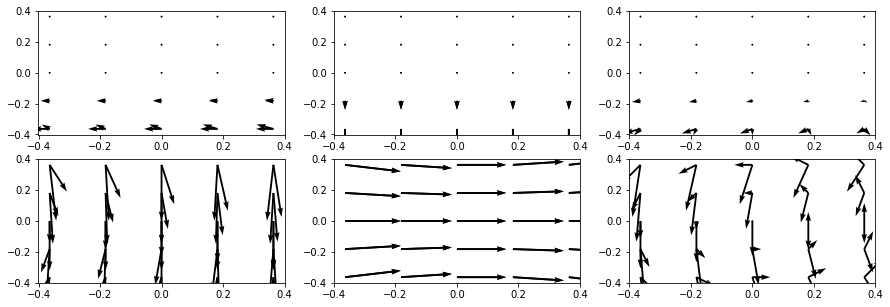

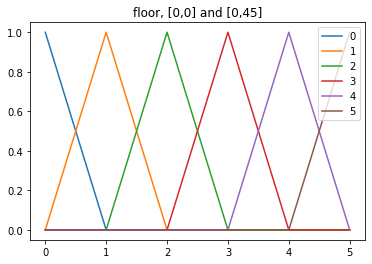

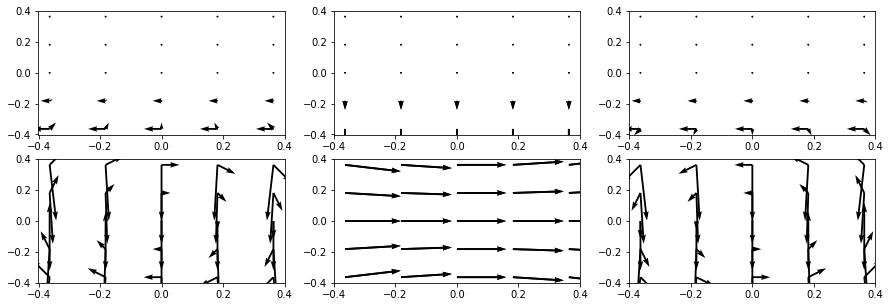

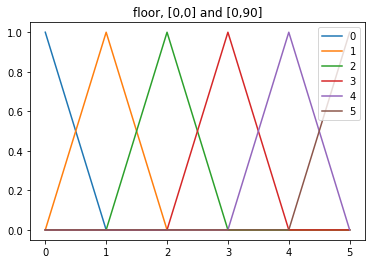

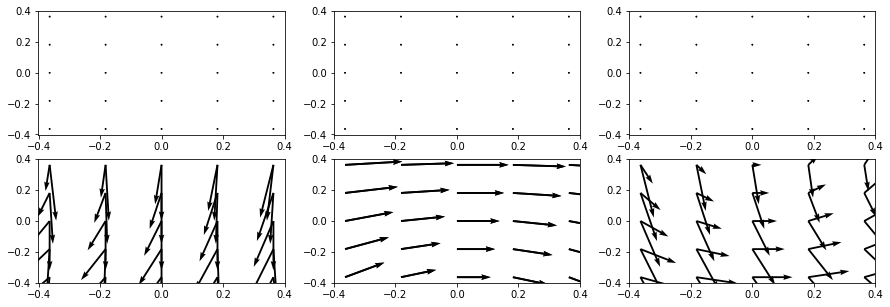

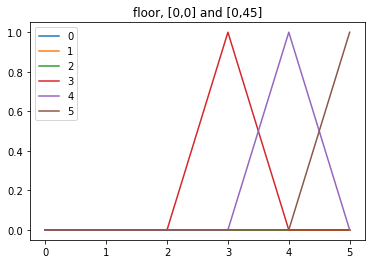

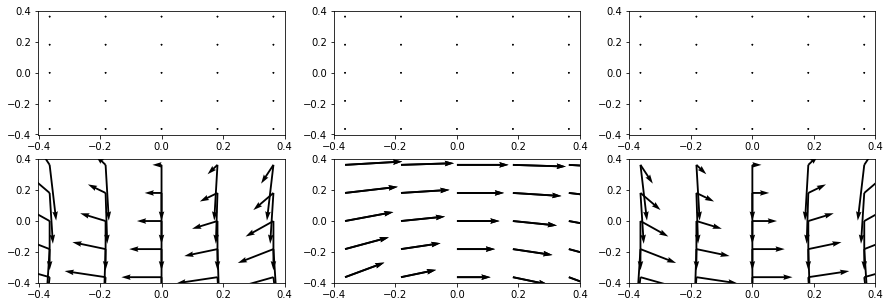

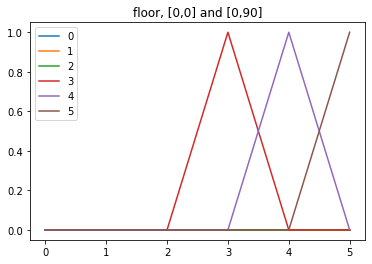

In [6]:
# plot flow templates and test flow prediction on noise-free unit vectors
for geometry in ['sphere','floor']:
    alphas = [0,0]
    for theta in [pi/4,pi/2]:
        flows = [getflow_multimodal(Vx=1,geometry=geometry,alphas=alphas,thetas=[0,theta]), \
                getflow_multimodal(Vy=1,geometry=geometry,alphas=alphas,thetas=[0,theta]), \
                getflow_multimodal(Vz=1,geometry=geometry,alphas=alphas,thetas=[0,theta]), \
                getflow_multimodal(Wx=1,geometry=geometry,alphas=alphas,thetas=[0,theta]), \
                getflow_multimodal(Wy=1,geometry=geometry,alphas=alphas,thetas=[0,theta]), \
                getflow_multimodal(Wz=1,geometry=geometry,alphas=alphas,thetas=[0,theta])]

        plt.figure(figsize=(15,5))
        for f,flow in enumerate(flows):
            plt.subplot(2,3,f+1)
            plt.quiver(xgrid2,ygrid2,flow[0],flow[1],scale=s)

        plt.figure()
        for f,flow in enumerate(flows):
            plt.plot(getvel_multimodal(flow,geometry=geometry,thetas=[0,theta],alphas=alphas),label=f)
        plt.legend()
        plt.title(f'{geometry}, [0,0] and [0,{theta*180/pi:.0f}]')
        
alphas = [30*pi/180,30*pi/180]
for theta in [pi/4,pi/2]:
    flows = [getflow_multimodal(Vx=1,geometry=geometry,alphas=alphas,thetas=[0,theta]), \
            getflow_multimodal(Vy=1,geometry=geometry,alphas=alphas,thetas=[0,theta]), \
            getflow_multimodal(Vz=1,geometry=geometry,alphas=alphas,thetas=[0,theta]), \
            getflow_multimodal(Wx=1,geometry=geometry,alphas=alphas,thetas=[0,theta]), \
            getflow_multimodal(Wy=1,geometry=geometry,alphas=alphas,thetas=[0,theta]), \
            getflow_multimodal(Wz=1,geometry=geometry,alphas=alphas,thetas=[0,theta])]

    plt.figure(figsize=(15,5))
    for f,flow in enumerate(flows):
        plt.subplot(2,3,f+1)
        plt.quiver(xgrid2,ygrid2,flow[0],flow[1],scale=s)

    plt.figure()
    for f,flow in enumerate(flows):
        plt.plot(getvel_multimodal(flow,geometry=geometry,thetas=[0,theta],alphas=alphas),label=f)
    plt.legend()
    plt.title(f'{geometry}, [0,0] and [0,{theta*180/pi:.0f}]')

In [7]:
# adding realistic noise: generalized Gaussian noise and sparsity by elevation

def gengaussnoise(sample,params,sparsity=.5,delvalue=np.nan):
    out = np.copy(sample)
    _,h = np.shape(sample)
    # add generalized Gaussian noise
    sig = params[0]
    beta = params[1]
    noise = sig*stats.gennorm.rvs(beta,size=2*h)
    noise = np.reshape(noise,[2,h])
    out = out+(noise*np.pi/180) # noise model based on deg/sec
    # sparsify
    delete = np.random.rand(h)>(1-sparsity)
    out[np.stack([delete,delete],axis=0)] = delvalue
    return out

# noise models -- see NoiseModel code and methods for details

# Lukas-Kanade
LK = {
    'name': 'LK',
    'params': np.array([[0.945543  , 0.41324449],
       [0.75939695, 0.40043585],
       [0.84083792, 0.41700667],
       [0.71956128, 0.43254874],
       [0.76700457, 0.46822423],
       [0.97988532, 0.51886733],
       [1.18255235, 0.55071252],
       [1.35039504, 0.56855028],
       [1.69578376, 0.59252586],
       [2.18604247, 0.6292485 ],
       [2.36382315, 0.62748426]]),
    'sparsities': [.6134260585, .6251135201, .6372243813, .6701022704, .6488167314, .5720433627,
                   .4841859276, .3977214154, .3323757415, .30228063,   .2793106975]}

# Farid-Simoncelli filters, cond cutoff 100, gradient cutoff 1e-5
FSloose = {
    'name':'FSloose',
    'params': np.array([[5.80200798, 0.62348484],
         [7.40977222, 0.67756233],
         [7.453949  , 0.6957459 ],
         [5.85091536, 0.65018788],
         [4.60132385, 0.63456327],
         [4.55511205, 0.67643774],
         [5.33933707, 0.72290557],
         [6.20683927, 0.7489752 ],
         [7.41741088, 0.78316624],
         [8.12447712, 0.80010563],
         [8.70822659, 0.81620346]]),
    'sparsities': [.6739508054, .6440313452, .6127154985, .6173019155, .5983924684, .5721821942,
                   .4315128428, .3377688289, .2685491946, .2392087505, .2351425773]}

# Farid-Simoncelli filters, cond cutoff 100, gradient cutoff 1e-4
FStight = {
    'name': 'FStight',
    'params': np.array([[3.99696437, 0.60115734],
         [4.32641709, 0.63828529],
         [4.59970119, 0.71239452],
         [3.99257113, 0.71552029],
         [3.9315006 , 0.73467338],
         [4.5674312 , 0.79315019],
         [5.07726186, 0.79983146],
         [5.72412255, 0.81096243],
         [6.75218297, 0.82503089],
         [7.60707337, 0.85143377],
         [8.31609976, 0.86289857]]),
    'sparsities': [.7843600348, .7829680017, .7962984327, .7892577275, .7561373531, .688321724,
                   .5855605137, .5137135394, .4488833261, .4039834567, .3777622987]}

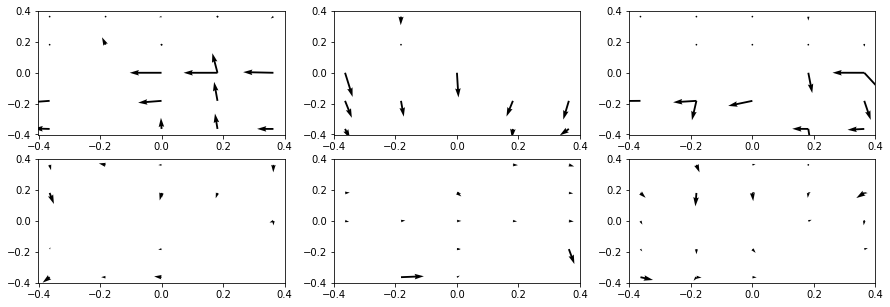

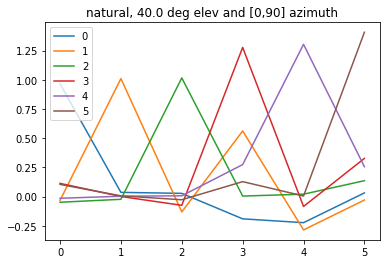

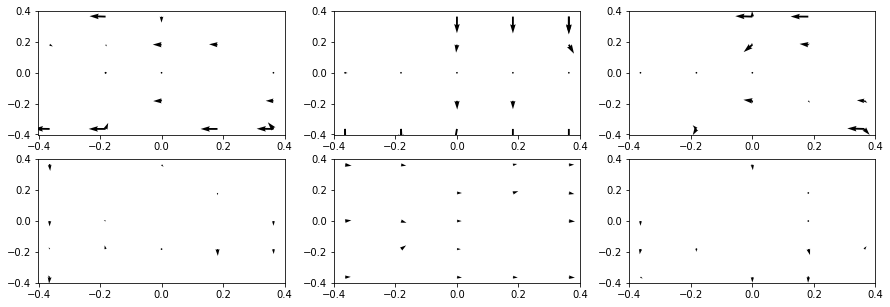

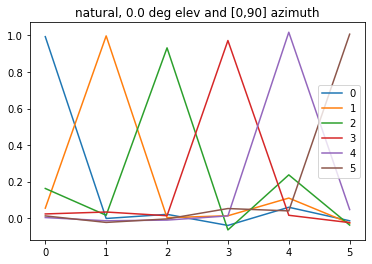

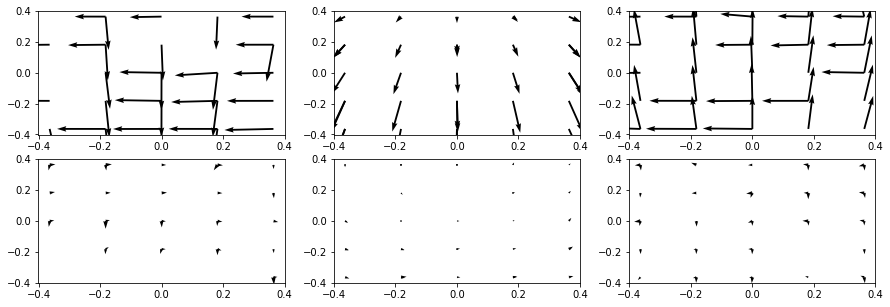

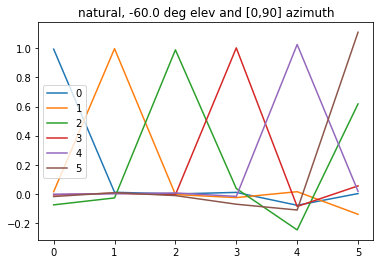

In [8]:
# plot flow templates and test flow prediction on realistically noisy and sparse unit flows
for geometry in ['natural']:
    theta = pi/2
    alphais = [0,4,-1]
    for i in alphais:
        alphas = [alphasrad[i],alphasrad[i]]
        cleanflows = [getflow_multimodal(Vx=1,geometry=geometry,alphas=alphas,thetas=[0,theta]), \
                getflow_multimodal(Vy=1,geometry=geometry,alphas=alphas,thetas=[0,theta]), \
                getflow_multimodal(Vz=1,geometry=geometry,alphas=alphas,thetas=[0,theta]), \
                getflow_multimodal(Wx=1,geometry=geometry,alphas=alphas,thetas=[0,theta]), \
                getflow_multimodal(Wy=1,geometry=geometry,alphas=alphas,thetas=[0,theta]), \
                getflow_multimodal(Wz=1,geometry=geometry,alphas=alphas,thetas=[0,theta])]

        flows = [gengaussnoise(cleanflow,LK['params'][i],LK['sparsities'][i]) for cleanflow in cleanflows]
        #flows = [gengaussnoise(cleanflow,[0,.01],.5) for cleanflow in cleanflows]

        plt.figure(figsize=(15,5))
        for f,flow in enumerate(flows):
            plt.subplot(2,3,f+1)
            plt.quiver(xgrid2,ygrid2,flow[0],flow[1],scale=10*s)

        plt.figure()
        for f,flow in enumerate(flows):
            plt.plot(getvel_multimodal(flow,geometry=geometry,thetas=thetas,alphas=alphas),label=f)
        plt.legend()
        plt.title(f'{geometry}, {alphasdeg[i]} deg elev and [0,{theta*180/pi:.0f}] azimuth')

In [9]:
# Experiment plan

# for each noise model, try each pairwise combo of location grid

# 4 behaviors:

#Saccadic translation:
#    Vz ~ U[0,1] + (Vx,Vz) ~U[-,5,.5]
#    2DOF recon
sacctrans = {
    'name': 'saccadictranslation',
    'Vzswim': 1,
    'Wyswim': 0,
    'drift': True,
    'DOFs': 2
}

#Fast saccadic rotation:
#    Wy ~ U[-100,100] + (Vx,Vz) ~U[-,5,.5]
#    1DOF recon
saccrot_fast = {
    'name': 'saccadicrotationfast',
    'Vzswim': 0,
    'Wyswim': 100,
    'drift': True,
    'DOFs': 1
}

#Drifting saccadic rotation:
#    Wy ~ U[-1,1] + (Vx,Vz) ~U[-,5,.5]
#    3DOF recon
saccrot_slow = {
    'name': 'saccadicrotationslow',
    'Vzswim': 0,
    'Wyswim': 1,
    'drift': True,
    'DOFs': 3
}

#Saccadic rotation without drift:
#    Wy ~ U[-1,1]
#    1DOF recon
saccrot_alone = {
    'name': 'saccadicrotationalone',
    'Vzswim': 0,
    'Wyswim': 1,
    'drift': False,
    'DOFs': 1
}

#Continuous swimming:
#    Vz ~ U[0,1]  Wy ~ U[-1,1] + Vx, Vz ~ U[-.5,.5]
#    3DOF recon
contswim = {
    'name': 'continuousswim',
    'Vzswim': 1,
    'Wyswim': 1,
    'drift': True,
    'DOFs': 3
}

In [10]:
# characterize multimodal errors
def getmultimodalerrs(thetas=[-pi/2,pi/2],alphas=[0,0],
                 x=xx,y=yy,
                 trials=10000,
                 noiseparams=[[1,.5],[1,.5]],
                 sparsities=[.66,.66],
                 geometry='natural',
                 DOFs=3,
                 Vzswim = 1,
                 Wyswim = 1,
                 drift=True,
                 plotit=False):

    errs = np.nan*np.ones([trials,DOFs+1])
    
    for i in range(trials): 
        
        # generate behavior
        Vx = Vy = Vz = Wx = Wy = Wz = 0
        # swim forward with speed between 0 and Vzswim
        Vz = Vzswim*np.random.rand()
        # rotate with speed between -Wyswim and Wyswim
        Wy = Wyswim*(2*np.random.rand()-1)
        # add drift from -.5 to .5 in Vx and Vz
        if drift:
            Vx = Vx + (np.random.rand()-.5)
            Vz = Vz + (np.random.rand()-.5)
            
        # create clean flow
        cleanflow = np.array(getflow_multimodal(geometry=geometry,thetas=thetas,alphas=alphas,x=x,y=y,
                         Vx=Vx,Vy=Vy,Vz=Vz,Wx=Wx,Wy=Wy,Wz=Wz))
        
        # add elevation-dependant noise and sparsity
        flow = np.zeros_like(cleanflow)
        flow[:,:patchsz] = gengaussnoise(cleanflow[:,:patchsz],noiseparams[0],sparsities[0])
        flow[:,patchsz:] = gengaussnoise(cleanflow[:,patchsz:],noiseparams[1],sparsities[1])
        
        # optionally, plot flows
        if plotit == True:
            plt.quiver(x,y,flow[0],flow[1],scale=10,color='r')
            plt.xlim(-np.pi,np.pi)
            plt.ylim(-np.pi/2 - 0.25,np.pi/2 + 0.25)
            plt.savefig(f'./plots/example_local_flow_{i}.eps', format='eps')

        # get prediction and errors
        preds = getvel_multimodal(flow,geometry=geometry,thetas=thetas,alphas=alphas,x=x,y=y,DOFs=DOFs)
        if DOFs == 3:
            gt =  [Vx,Vz,Wy]
        elif DOFs == 2:
            gt = [Vx,Vz]
        elif DOFs == 1:
            gt = [Wy]
        errs[i,:DOFs] = preds-gt
    
        # heading error
        if DOFs > 1:
            headinggt = np.arctan2(gt[0],gt[1])
            headingpred = np.arctan2(preds[0],preds[1])
            headingerr = anglediff(headingpred,headinggt,deg=False)
            errs[i,-1] = headingerr

    return errs

In [11]:
# coarse spatial sampling for base receptive fields
baseas = [2,4,6,8,10]
basets = [18,21,24,27]
print(alphasdeg[baseas],thetasdeg[basets])

[ 20.   0. -20. -40. -60.] [ 0. 30. 60. 90.]


In [ ]:
models = [LK,FSloose,FStight]
behaviors = [sacctrans,saccrot_fast,saccrot_slow,contswim,saccrot_alone]
behaviors.reverse()

ntrials = 10000

for model in [FSloose,FStight]:
    print(f'*******{model["name"]}*******')
    for behavior in behaviors:
        print(f'---{behavior["name"]}---')
        
        outdir = f'./fish_simulation_files/{model["name"]}/{behavior["name"]}/'
        os.makedirs(outdir,exist_ok=True)
        
        for basea in baseas:
            for baset in basets:
                print(f'\t{alphasdeg[basea]},{thetasdeg[baset]}')
                
                files = os.listdir(outdir)
                if len(files)>0:
                    done = np.max([file.startswith(f'{alphasdeg[basea]}elev_{thetasdeg[baset]}azim_{ntrials}trials') for file in files])
                    if done:
                        continue
                
                errs = np.nan*np.ones([len(alphasrad),len(thetasrad),behavior['DOFs']+1])

                for a in range(len(alphasrad)):
                    for t in range(len(thetasrad)):

                        locerrs = getmultimodalerrs(
                                 thetas=[thetasrad[baset],thetasrad[t]],
                                 alphas=[alphasrad[basea],alphasrad[a]],
                                 trials=ntrials,
                                 noiseparams=[model['params'][basea],model['params'][a]],
                                 sparsities=[model['sparsities'][basea],model['sparsities'][a]],
                                 DOFs=behavior['DOFs'],
                                 Vzswim=behavior['Vzswim'],
                                 Wyswim=behavior['Wyswim'],
                                 drift=behavior['drift'])
                        errs[a,t,:] = np.nanmedian(np.abs(locerrs),axis=0)

                timestr = time.strftime("%Y%m%d-%H%M%S")
                outfile = f'{outdir}{alphasdeg[basea]}elev_{thetasdeg[baset]}azim_{ntrials}trials_{timestr}'
                np.savez(outfile,errs=errs)

*******EMDloose*******
---saccadicrotationalone---
	20.0,0.0


C:\Users\EA\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


	20.0,30.0
	20.0,60.0
	20.0,90.0


In [ ]:
#### global ####

In [ ]:
# simulation parameters to run
repeats       = 10000      # 10000
batch_size    = 10000      # 10000

subset_size   = 20         # 20 bimodal 40x40 deg fields of view cover all azimuths, -60 to +40 deg in elevation
geometry      ='natural'   
behavior_DOFs = 3          # 3, 2, or 1

In [ ]:
# make grid of azimuth (theta) and elevation (alpha) coordinates

# full res
theta_mat,alpha_mat = np.meshgrid(thetasrad,alphasrad)

# flatten matrices
thetas = theta_mat.flatten()
alphas = alpha_mat.flatten()

# remove negative asimuths, as they're included by 180 deg spacing in bimodal pairs
alphas = alphas[thetas >= 0]
thetas = thetas[thetas >= 0]

In [ ]:
# for a given set of indices, runs a batch of self motion trajectories and calculates the errors
def error_calc(indexset,trials=10,geometry='natural',
               theta=thetas,alpha=alphas,x=xx,y=yy,
               DOFs=3,Vzswim=1,Wyswim=1,drift=True,
               noiseparams=[[1,.5],[1,.5]],sparsities=[.66,.66]):

    errs = np.nan*np.ones([trials,DOFs+1])
    
    # subset
    this_subset_thetas = thetas[indexset]
    this_subset_alphas = alphas[indexset]

    # include patches 180 degrees away in azimuth
    this_subset_thetas = np.append(this_subset_thetas,this_subset_thetas-pi)
    this_subset_alphas = np.append(this_subset_alphas,this_subset_alphas)
    
    for i in range(trials): 
       
     # generate behavior
        Vx = Vy = Vz = Wx = Wy = Wz = 0
        # swim forward with speed between 0 and Vzswim
        Vz = Vzswim*np.random.rand()
        # rotate with speed between -Wyswim and Wyswim
        Wy = Wyswim*(2*np.random.rand()-1)
        # add drift from -.5 to .5 in Vx and Vz
        if drift:
            Vx = Vx + (np.random.rand()-.5)
            Vz = Vz + (np.random.rand()-.5)
            
        # create clean flow
        cleanflow = np.array(getflow_multimodal(geometry=geometry,thetas=this_subset_thetas,alphas=this_subset_alphas,x=x,y=y,
                         Vx=Vx,Vy=Vy,Vz=Vz,Wx=Wx,Wy=Wy,Wz=Wz))
        
        # add elevation-dependant noise and sparsity
        flow = np.zeros_like(cleanflow)
        alphainds = [np.argmin(np.abs(alpha-alphasrad)) for alpha in this_subset_alphas]
        for j in range(len(this_subset_alphas)): 
            flow[:,j*patchsz:(j+1)*patchsz] = gengaussnoise(cleanflow[:,j*patchsz:(j+1)*patchsz],
                                                          noiseparams[alphainds[j]],
                                                          sparsities[alphainds[j]])

        # get prediction and errors
        preds = getvel_multimodal(flow,geometry=geometry,thetas=this_subset_thetas,alphas=this_subset_alphas,x=x,y=y,DOFs=DOFs,
                                  weightsin=np.ones(patchsz*len(this_subset_alphas)))

        if DOFs == 3:
            gt =  [Vx,Vz,Wy]
        elif DOFs == 2:
            gt = [Vx,Vz]
        elif DOFs == 1:
            gt = [Wy]
        errs[i,:DOFs] = preds-gt
                      
        # heading error
        if DOFs > 1:
            headinggt = np.arctan2(gt[0],gt[1])
            headingpred = np.arctan2(preds[0],preds[1])
            headingerr = anglediff(headingpred,headinggt,deg=False)
            errs[i,-1] = headingerr

    return np.median(np.abs(errs),axis=0)

In [ ]:
# check that error calculation runs
this_subset_inds = np.random.randint(0, high=int(np.size(thetas)), size=int(subset_size))
error_calc(this_subset_inds,trials=1000,geometry='sphere',theta=thetas,alpha=alphas,DOFs=3,noiseparams=LK['params'],sparsities=LK['sparsities'])

<ipython-input-108-3636e6c2f172>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  errs[i,:DOFs] = preds-gt


array([0.00966928, 0.00891529, 0.01007535, 0.01626034])

In [ ]:
# run saccadic translation and continuous swim under LK

In [ ]:
# run global sim a bunch of times

models = [LK,FSloose,FStight]
behaviors = [contswim]
repeats_left = 10000

for model in models:
    for behavior in behaviors:
        
        # initialize results        
        all_subset_inds = np.ones([repeats_left,subset_size],dtype = np.int16)
        all_err_Vz      = np.zeros(repeats_left)
        all_err         = np.zeros([repeats_left,behavior["DOFs"]+1])
        running_sum     = np.zeros_like(thetas)
        running_count   = np.zeros_like(thetas)

        
        for i in range(repeats_left):

            this_subset_inds = np.random.randint(0, high=int(np.size(thetas)), size=int(subset_size))
            all_subset_inds[i,:] = this_subset_inds

            errs = error_calc(this_subset_inds,trials=batch_size,theta=thetas,alpha=alphas,
                             DOFs=behavior['DOFs'], 
                             Vzswim=behavior['Vzswim'],
                             Wyswim=behavior['Wyswim'],
                             drift=behavior['drift'],
                             noiseparams=model['params'],
                             sparsities=model['sparsities'])
            
            err_Vz = errs[1]
            all_err[i,:] = errs
            all_err_Vz[i] = err_Vz

            running_sum[this_subset_inds] = running_sum[this_subset_inds] + err_Vz
            running_count[this_subset_inds] = running_count[this_subset_inds] + 1

            # visualize intermediate results
            if np.mod(i+1,100) == 0 or i+1 == repeats_left:

                # calculate weighted average
                weighted_average = running_sum/running_count

                #clear_output(wait=True)

                # plot weighted average
                plt.figure(figsize=(15,5))
                plt.title(f'Current progress:{np.round(100*(i+1)/(repeats_left),2)}')
                plt.scatter(thetas,alphas,c=weighted_average,cmap='Reds')
                # to set color limit use e.g. norm=colors.LogNorm((vmin=1,vmax=5)) in line above
                plt.colorbar()
                plt.show()

                timestr = time.strftime("%Y%m%d-%H%M%S")
                np.savez(f'./fish_simulation_files/global_{model["name"]}_{behavior["name"]}_{batch_size}batchsize_{repeats_left}repeats_{timestr}',repeats=i+1,batch_size=batch_size,subset_size=subset_size,thetas=thetas,alphas=alphas,all_subset_inds=all_subset_inds,all_err=all_err,all_err_Vz=all_err_Vz,running_sum=running_sum,running_count=running_count,weighted_average=weighted_average)


In [ ]:
# discussion analysis: what happens when upper field is twice as densely sampled?
# this can be simulated by quartering sparsity in upper field

# Lukas-Kanade with upper field sparsity halved
LK_modified4 = {
    'name': 'LKmodified4',
    'params': np.array([[0.945543  , 0.41324449],
       [0.75939695, 0.40043585],
       [0.84083792, 0.41700667],
       [0.71956128, 0.43254874],
       [0.76700457, 0.46822423],
       [0.97988532, 0.51886733],
       [1.18255235, 0.55071252],
       [1.35039504, 0.56855028],
       [1.69578376, 0.59252586],
       [2.18604247, 0.6292485 ],
       [2.36382315, 0.62748426]]),
    'sparsities': [.6134260585/4, .6251135201/4, .6372243813/4, .6701022704/4, .6488167314, .5720433627,
                   .4841859276, .3977214154, .3323757415, .30228063,   .2793106975]}

behavior = contswim
model = LK_modified4

outdir = f'./fish_simulation_files/{model["name"]}/{behavior["name"]}/'
os.makedirs(outdir,exist_ok=True)

ntrials = 10000

for basea in [baseas[0]]:#baseas:
    for baset in [basets[-1]]:#basets:
        print(f'\t{alphasdeg[basea]},{thetasdeg[baset]}')

        files = os.listdir(outdir)
        if len(files)>0:
            done = np.max([file.startswith(f'{alphasdeg[basea]}elev_{thetasdeg[baset]}azim_{ntrials}trials') for file in files])
            if done:
                continue

        errs = np.nan*np.ones([len(alphasrad),len(thetasrad),behavior['DOFs']+1])

        for a in range(len(alphasrad)):
            for t in range(len(thetasrad)):

                locerrs = getmultimodalerrs(
                         thetas=[thetasrad[baset],thetasrad[t]],
                         alphas=[alphasrad[basea],alphasrad[a]],
                         trials=ntrials,
                         noiseparams=[model['params'][basea],model['params'][a]],
                         sparsities=[model['sparsities'][basea],model['sparsities'][a]],
                         DOFs=behavior['DOFs'],
                         Vzswim=behavior['Vzswim'],
                         Wyswim=behavior['Wyswim'],
                         drift=behavior['drift'])
                errs[a,t,:] = np.nanmedian(np.abs(locerrs),axis=0)

        timestr = time.strftime("%Y%m%d-%H%M%S")
        outfile = f'{outdir}{alphasdeg[basea]}elev_{thetasdeg[baset]}azim_{ntrials}trials_{timestr}'
        np.savez(outfile,errs=errs)

	20.0,90.0
